In [ ]:
import os, glob, random, warnings
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
import cv2, matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support, 
                             confusion_matrix, roc_curve, auc, roc_auc_score)

In [ ]:
warnings.filterwarnings('ignore')
SEED   = 42
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

In [ ]:
# ---------- root detection ----------
CANDIDATES = [
    Path('/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'),
    Path('/kaggle/input/Dataset_BUSI_with_GT'),
    Path('/kaggle/input/dataset_busi_with_gt'),
    Path('Dataset_BUSI_with_GT'),
]
for cand in CANDIDATES:
    if cand.exists():
        ROOT = cand
        break
else:
    raise FileNotFoundError('BUSI dataset not found. Attach it via "Add data".')

print('Using dataset folder:', ROOT)

In [ ]:
# ---------- gather image / mask pairs ----------
MASKS = sorted(ROOT.rglob('*_mask.png'))      # recursive search
IMGS  = [str(p).replace('_mask','') for p in MASKS]

records = []
for img, msk in zip(IMGS, MASKS):
    folder = Path(img).parent.name.lower()       # benign / malignant / normal
    label  = {'normal':0, 'benign':1, 'malignant':2}[folder]
    if os.path.exists(img) and os.path.exists(msk):
        records.append((img, msk, label))

df = pd.DataFrame(records, columns=['image','mask','label'])
print('Total images :', len(df), '\nClass counts:\n', df['label'].value_counts())

In [ ]:
# =============== 2. Train-val split =========================
train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df['label'], random_state=SEED)

In [ ]:
# =============== 3. Transforms ==============================
IMG_SIZE = 256

train_tf = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor()
])

val_tf = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor()
])

In [ ]:
# =============== 4. Dataset class ===========================
class BUSIDataset(Dataset):
    def __init__(self, dataframe, transform, apply_preprocess=True):
        self.df = dataframe.reset_index(drop=True)
        self.t = transform
        self.apply_preprocess = apply_preprocess

    def __len__(self): return len(self.df)
    
    def preprocess_image(self, img_np):
        """Apply noise reduction and morphological operations"""
        img_np = cv2.GaussianBlur(img_np, (5, 5), 0)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img_np = clahe.apply(img_np)
        kernel = np.ones((3, 3), np.uint8)
        img_np = cv2.morphologyEx(img_np, cv2.MORPH_OPEN, kernel)
        return img_np
def __getitem__(self, idx):
        img = Image.open(self.df.loc[idx,'image']).convert('L')
        msk = Image.open(self.df.loc[idx,'mask']).convert('L')
        
        if self.apply_preprocess:
            img_np = self.preprocess_image(np.array(img).astype(np.uint8))
            img = Image.fromarray(img_np)
        
        img = self.t(img)
        msk = self.t(msk)
        lbl = torch.tensor(self.df.loc[idx,'label']).long()
        msk = (msk > 0).float()          # binarise
        
        return img, msk, lbl

# Dataloaders
BATCH = 16
train_loader = DataLoader(BUSIDataset(train_df, train_tf, True), BATCH, shuffle=True)
val_loader   = DataLoader(BUSIDataset(val_df  , val_tf  , True), BATCH, shuffle=False)

In [ ]:
# =============== 5. Model ===================================
class ConvBlock(nn.Module):
    def __init__(self, c_in, c_out):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(c_in, c_out, 3, padding=1), nn.BatchNorm2d(c_out), nn.ReLU(inplace=True),
            nn.Conv2d(c_out, c_out, 3, padding=1), nn.BatchNorm2d(c_out), nn.ReLU(inplace=True))
    def forward(self,x): return self.seq(x)

class Encoder(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = ConvBlock(in_c, out_c)
        self.pool = nn.MaxPool2d(2)
    def forward(self, x):
        f = self.conv(x)
        p = self.pool(f)
        return f, p
class Decoder(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up   = nn.ConvTranspose2d(in_c, out_c, 2, 2)
        self.conv = ConvBlock(out_c*2, out_c)
    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], 1)
        return self.conv(x)

class MultiTaskUNet(nn.Module):
    def __init__(self, n_classes=3):
        super().__init__()
        self.e1 = Encoder(1, 64);  self.e2 = Encoder(64, 128)
        self.e3 = Encoder(128, 256); self.e4 = Encoder(256, 512)
        self.btl = ConvBlock(512, 1024)
        self.d1 = Decoder(1024, 512); self.d2 = Decoder(512, 256)
        self.d3 = Decoder(256, 128);  self.d4 = Decoder(128, 64)
        self.seg_out = nn.Conv2d(64, 1, 1)
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(1024, 256), nn.ReLU(),
            nn.Linear(256, n_classes))
    def forward(self, x):
        x1, p1 = self.e1(x)
        x2, p2 = self.e2(p1)
        x3, p3 = self.e3(p2)
        x4, p4 = self.e4(p3)
        bott   = self.btl(p4)
        s = self.d1(bott, x4); s = self.d2(s, x3)
        s = self.d3(s, x2);   s = self.d4(s, x1)
        seg_logits = self.seg_out(s).squeeze(1)   # (B,H,W)
        cls_logits = self.cls_head(bott)
        return seg_logits, cls_logits

model = MultiTaskUNet().to(DEVICE)

In [ ]:
# =============== 6. Losses & Metrics ========================
bce_loss  = nn.BCEWithLogitsLoss()
dice_loss = lambda l,t : 1. - (2*(torch.sigmoid(l)*t).sum() + 1.) / \
                         (torch.sigmoid(l).sum() + t.sum() + 1.)
cls_loss_fn = nn.CrossEntropyLoss()

def seg_scores(logits, masks, thr=0.5):
    probs = torch.sigmoid(logits)
    preds = (probs > thr).float()
    inter = (preds*masks).sum((1,2))
    union = preds.sum((1,2)) + masks.sum((1,2)) - inter
    iou   = (inter / (union + 1e-6)).mean()
    dice  = (2*inter / (preds.sum((1,2))+masks.sum((1,2))+1e-6)).mean()
    pix   = (preds == masks).float().mean()
    return iou.item(), dice.item(), pix.item()

def cls_scores(logits, labels):
    preds = logits.argmax(1).cpu().numpy()
    labels = labels.cpu().numpy()
    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted', zero_division=0)
    return acc, prec, rec, f1

In [ ]:
# =============== 7. Trainer =================================
def train_one_epoch(model, loader, optimizer, alpha=0.6, beta=0.4,
                    log_interval=10, epoch=0, total_epochs=0):
    model.train()
    running,n_seen = defaultdict(float),0
    
    for it, (imgs, masks, lbls) in enumerate(loader, 1):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE).squeeze(1)
        lbls = lbls.to(DEVICE)
        
        seg_logits, cls_logits = model(imgs)
        seg_loss = 0.2*bce_loss(seg_logits, masks) + 0.8*dice_loss(seg_logits, masks)
        cls_loss = cls_loss_fn(cls_logits, lbls)
        loss     = alpha*seg_loss + beta*cls_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        bs = imgs.size(0); n_seen += bs
        running['loss']     += loss.item()*bs
        running['seg_loss'] += seg_loss.item()*bs
        running['cls_loss'] += cls_loss.item()*bs
        
        iou, dsc, pix = seg_scores(seg_logits.detach(), masks)
        running['iou']  += iou*bs; running['dice'] += dsc*bs; running['pix'] += pix*bs
        
        acc, prec, rec, f1 = cls_scores(cls_logits.detach(), lbls)
        running['acc'] += acc*bs; running['prec']+=prec*bs
        running['rec']+=rec*bs;  running['f1']+=f1*bs
        
        if it % log_interval == 0:
            print(f"[{epoch}/{total_epochs}] "
                  f"{it:03d}/{len(loader)}  "
                  f"Loss {loss.item():.4f} | Seg {seg_loss.item():.4f} "
                  f"Cls {cls_loss.item():.4f} | IoU {iou:.3f} Dice {dsc:.3f} "
                  f"Acc {acc:.3f}")
    
    for k in running: running[k] /= n_seen
    return running

@torch.no_grad()
def evaluate(model, loader, alpha=0.6, beta=0.4):
    model.eval(); tot,n_seen = defaultdict(float),0
    for imgs, masks, lbls in loader:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE).squeeze(1)
        lbls = lbls.to(DEVICE)
        seg_logits, cls_logits = model(imgs)
        seg_loss = 0.2*bce_loss(seg_logits, masks) + 0.8*dice_loss(seg_logits, masks)
        cls_loss = cls_loss_fn(cls_logits, lbls)
        loss     = alpha*seg_loss + beta*cls_loss
        
        bs = imgs.size(0); n_seen += bs
        tot['loss']     += loss.item()*bs
        tot['seg_loss'] += seg_loss.item()*bs
        tot['cls_loss'] += cls_loss.item()*bs
        
        iou, dsc, pix = seg_scores(seg_logits, masks)
        tot['iou'] += iou*bs; tot['dice']+=dsc*bs; tot['pix']+=pix*bs
        
        acc, prec, rec, f1 = cls_scores(cls_logits, lbls)
        tot['acc']+=acc*bs; tot['prec']+=prec*bs; tot['rec']+=rec*bs; tot['f1']+=f1*bs
        
    for k in tot: tot[k] /= n_seen
    return tot

In [ ]:
# =============== 8. Main train loop =========================
EPOCHS, MAX_PATIENCE = 100, 30
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3, verbose=True)

history_keys = ['loss','dice','iou','pixAcc','acc','prec','rec','f1']
history = {f'{p}_{k}':[] for p in ['train','val'] for k in history_keys}
history['lr'] = []

best_dice,best_epoch,patience_counter = 0.,0,0
ckpt_path = 'best_multitask_unet.pth'

print("\nStarting training loop...")
for ep in range(1, EPOCHS+1):
    history['lr'].append(optimizer.param_groups[0]['lr'])
    
    tr = train_one_epoch(model, train_loader, optimizer,
                         epoch=ep, total_epochs=EPOCHS, log_interval=15)
    vl = evaluate(model, val_loader)
    scheduler.step(vl['dice'])
    
    # store
    for k in history_keys:
        tr_key = k if k!='pixAcc' else 'pix'
        history[f'train_{k}'].append(tr[tr_key])
        history[f'val_{k}'].append(vl[tr_key])
    
    print(f"\n===> Epoch {ep:02d} Summary | "
          f"Train Dice {tr['dice']:.3f} | Val Dice {vl['dice']:.3f} | "
          f"Val IoU {vl['iou']:.3f} | Val Acc {vl['acc']:.3f}")
    
    # checkpoint
    if vl['dice'] > best_dice:
        best_dice,best_epoch = vl['dice'], ep
        torch.save({'epoch':ep,
                    'model_state_dict':model.state_dict(),
                    'optimizer_state_dict':optimizer.state_dict(),
                    'scheduler_state_dict':scheduler.state_dict(),
                    'best_dice':best_dice,
                    'history':history}, ckpt_path)
        print(f"Saved new best model (Dice={best_dice:.4f})\n")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"No improvement for {patience_counter} epochs")
    if patience_counter >= MAX_PATIENCE:
        print("\nEarly stopping triggered!")
        break

# -----------------------------------------------------------------
# 8-BIS  –  force a checkpoint if none was written
# -----------------------------------------------------------------
from pathlib import Path
if not Path(ckpt_path).exists():          # ckpt_path == 'best_multitask_unet.pth'
    torch.save(model.state_dict(), ckpt_path)
    print(f'No best-model file found → saved last-epoch weights to {ckpt_path}')
# -----------------------------------------------------------------

print(f"Training complete. Best val Dice {best_dice:.4f} @ epoch {best_epoch}")

In [ ]:
# =============== 9. Curves =================================
plt.figure(figsize=(18,12))
plt.subplot(2,3,1); plt.plot(history['train_loss']); plt.plot(history['val_loss'])
plt.title('Loss'); plt.legend(['train','val']); plt.grid()
plt.subplot(2,3,2); plt.plot(history['train_dice']); plt.plot(history['val_dice'])
plt.title('Dice'); plt.legend(['train','val']); plt.grid()
plt.subplot(2,3,3); plt.plot(history['train_iou']);  plt.plot(history['val_iou'])
plt.title('IoU'); plt.legend(['train','val']); plt.grid()
plt.subplot(2,3,4); plt.plot(history['train_acc']);  plt.plot(history['val_acc'])
plt.title('Acc'); plt.legend(['train','val']); plt.grid()
plt.subplot(2,3,5); plt.plot(history['train_f1']);   plt.plot(history['val_f1'])
plt.title('F1');  plt.legend(['train','val']); plt.grid()
plt.subplot(2,3,6); plt.plot(history['lr'],'o-'); plt.yscale('log'); plt.title('LR'); plt.grid()
plt.tight_layout(); plt.savefig('training_curves.png',dpi=300); plt.show()

# =============== 9.1 Final evaluation ======================
checkpoint = torch.load(ckpt_path, map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict']); model.eval()

final_train = evaluate(model, train_loader); final_val = evaluate(model, val_loader)
print("\n=== Quantitative Results (best epoch) ===")
print(f"Seg -> Train Dice {final_train['dice']:.3f} | Val Dice {final_val['dice']:.3f}")
print(f"Cls -> Train Acc  {final_train['acc'] :.3f} | Val Acc  {final_val['acc'] :.3f}")

# =============== 9.2 Confusion-matrix / ROC ================
all_lbls, all_preds, all_probs = [], [], []
with torch.no_grad():
    for imgs, _, lbls in val_loader:
        imgs = imgs.to(DEVICE)
        _, cls_logits = model(imgs)
        probs = torch.softmax(cls_logits,1).cpu()
        preds = probs.argmax(1)
        all_lbls.extend(lbls.numpy())
        all_preds.extend(preds.numpy())
        all_probs.extend(probs.numpy())

all_lbls, all_preds, all_probs = map(np.array,[all_lbls,all_preds,all_probs])
cm = confusion_matrix(all_lbls, all_preds)
class_names = ['Normal','Benign','Malignant']
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cbar=False, 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Pred'); plt.ylabel('True'); plt.title('Confusion matrix')
plt.tight_layout(); plt.savefig('confusion_matrix.png',dpi=300); plt.show()

# ROC
plt.figure(figsize=(7,6))
for i,c in enumerate(class_names):
    y_true = (all_lbls==i).astype(int)
    fpr,tpr,_ = roc_curve(y_true, all_probs[:,i])
    plt.plot(fpr,tpr,label=f'{c} (AUC={auc(fpr,tpr):.3f})')
plt.plot([0,1],[0,1],'k--'); plt.xlim(0,1); plt.ylim(0,1.05)
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC – One-vs-Rest')
plt.legend(); plt.grid(); plt.tight_layout(); plt.savefig('roc_curves.png',dpi=300); plt.show()

print("\nMacro-AUC :", roc_auc_score(np.eye(3)[all_lbls], all_probs,
                                     multi_class='ovr', average='macro'))

In [ ]:
# =============== 10. Qualitative examples ==================
samples,iou_scores,cls_results = [],[],[]
with torch.no_grad():
    for imgs,masks,lbls in val_loader:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE).squeeze(1)
        lbls = lbls.to(DEVICE)
        seg_logits, cls_logits = model(imgs)
        probs = torch.sigmoid(seg_logits).cpu()
        preds_cls = cls_logits.argmax(1).cpu()
        for i in range(imgs.size(0)):
            img_i, mask_i, prob_i = imgs[i].cpu(), masks[i].cpu(), probs[i]
            pred_bin = (prob_i>0.5).float()
            inter = (pred_bin*mask_i).sum().item()
            union = pred_bin.sum().item()+mask_i.sum().item()-inter
            iou = inter/(union+1e-6)
            samples.append((img_i,mask_i,prob_i))
            iou_scores.append(iou)
            cls_results.append((lbls[i].item(), preds_cls[i].item()))

top3,low3 = np.argsort(iou_scores)[-3:][::-1], np.argsort(iou_scores)[:3]
def plot_triplet(img_t,mask_t,pred_t,title,cls_info=None):
    img = img_t.squeeze().numpy(); mask = mask_t.squeeze().numpy()
    prob = pred_t.squeeze().numpy(); bin_ = (prob>0.5).astype(float)
    fig,ax = plt.subplots(1,4,figsize=(14,3.5))
    ax[0].imshow(img ,cmap='gray'); ax[0].set_title('Image'); ax[0].axis('off')
    ax[1].imshow(mask,cmap='gray'); ax[1].set_title('GT');    ax[1].axis('off')
    ax[2].imshow(prob,cmap='jet');  ax[2].set_title('Pred');  ax[2].axis('off')
    ax[3].imshow(img,cmap='gray');  ax[3].imshow(bin_,alpha=.5,cmap='Reds')
    ax[3].set_title('Overlay'); ax[3].axis('off')
    if cls_info:
        t,p = cls_info; plt.suptitle(f"{title}\nTrue:{class_names[t]} | Pred:{class_names[p]}")
    else:
        plt.suptitle(title)
    plt.tight_layout(rect=[0,0,1,0.9])
    return fig   # ---- PATCH: return figure so caller can save it

def save_examples():
    """
    Save and display qualitative segmentation / classification results.

    The function creates a folder called 'qualitative_examples' (if it
    does not already exist) and stores six PNG files:
        • good_case_1/2/3.png         – highest-IoU samples
        • challenging_case_1/2/3.png  – lowest-IoU  samples
    """
    out_dir = Path('qualitative_examples')
    out_dir.mkdir(exist_ok=True)

    # -------- Good (highest-IoU) cases ----------
    print('\n=== Good Cases (highest IoU) ===')
    for rank, idx in enumerate(top3, 1):
        fig = plot_triplet(
            *samples[idx],
            title=f'Good #{rank} | IoU={iou_scores[idx]:.3f}',
            cls_info=cls_results[idx]
        )
        fig.savefig(out_dir / f'good_case_{rank}.png',
                    dpi=300, bbox_inches='tight')
        plt.show(fig)
        plt.close(fig)

    # -------- Challenging (lowest-IoU) cases ----------
    print('\n=== Challenging Cases (lowest IoU) ===')
    for rank, idx in enumerate(low3, 1):
        fig = plot_triplet(
            *samples[idx],
            title=f'Challenging #{rank} | IoU={iou_scores[idx]:.3f}',
            cls_info=cls_results[idx]
        )
        fig.savefig(out_dir / f'challenging_case_{rank}.png',
                    dpi=300, bbox_inches='tight')
        plt.show(fig)
        plt.close(fig)

In [ ]:
# ------------------------------------------------------------------
#  Call the qualitative-example helper
# ------------------------------------------------------------------
save_examples()


# ------------------------------------------------------------------
# 11.  Model summary (torchinfo if available, else minimal)
# ------------------------------------------------------------------
try:
    from torchinfo import summary
    print("\nTorchinfo summary:")
    summary(model,
            input_size=(1, 1, IMG_SIZE, IMG_SIZE),
            col_names=("input_size", "output_size", "num_params"))
except (ImportError, ModuleNotFoundError):
    print("\nOptional: pip install torchinfo for a detailed layer table.")
    total_params = sum(p.numel() for p in model.parameters())
    print("\nManual model summary")
    print(f"Input size            : (1, 1, {IMG_SIZE}, {IMG_SIZE})")
    print(f"Total learnable params: {total_params:,}")
    print(f"Segmentation output   : (B, {IMG_SIZE}, {IMG_SIZE})")
    print("Classification output : (B, 3)  –  [Normal, Benign, Malignant]")

print("\nAll done – best checkpoint saved to", ckpt_path)

Using dataset folder: /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT
Total images : 780 
Class counts:
 label
1    437
2    210
0    133
Name: count, dtype: int64

Starting training loop...
[1/100] 015/39  Loss 0.7528 | Seg 0.8008 Cls 0.6807 | IoU 0.091 Dice 0.145 Acc 0.750
[1/100] 030/39  Loss 0.7631 | Seg 0.7970 Cls 0.7123 | IoU 0.107 Dice 0.179 Acc 0.688

===> Epoch 01 Summary | Train Dice 0.180 | Val Dice 0.147 | Val IoU 0.087 | Val Acc 0.269
Saved new best model (Dice=0.1466)

[2/100] 015/39  Loss 0.7183 | Seg 0.7614 Cls 0.6536 | IoU 0.076 Dice 0.124 Acc 0.812
[2/100] 030/39  Loss 0.8778 | Seg 0.7217 Cls 1.1120 | IoU 0.167 Dice 0.258 Acc 0.625

===> Epoch 02 Summary | Train Dice 0.226 | Val Dice 0.230 | Val IoU 0.157 | Val Acc 0.417
Saved new best model (Dice=0.2299)

[3/100] 015/39  Loss 0.6352 | Seg 0.6953 Cls 0.5449 | IoU 0.119 Dice 0.183 Acc 0.812
[3/100] 030/39  Loss 0.6590 | Seg 0.6577 Cls 0.6609 | IoU 0.221 Dice 0.310 Acc 0.688

===> Epoch 03 Summary | 

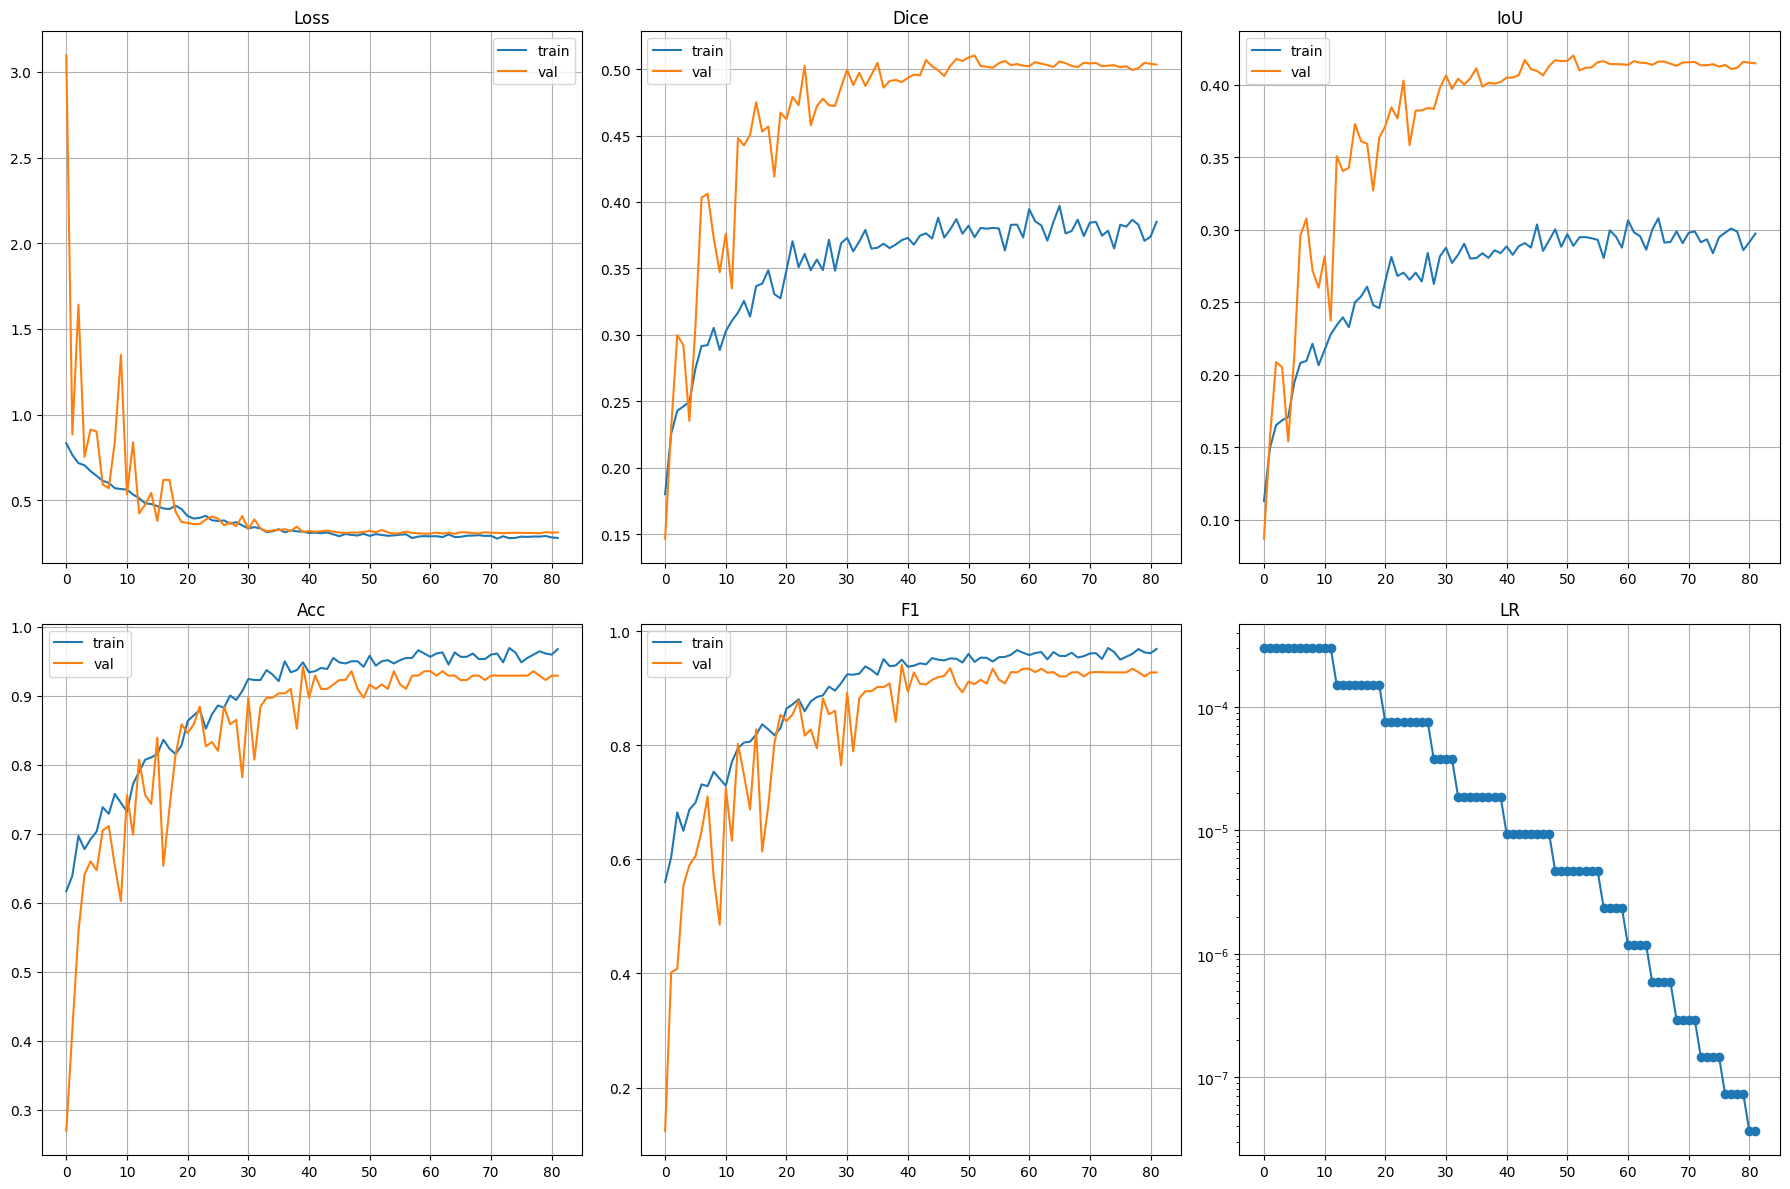


=== Quantitative Results (best epoch) ===
Seg -> Train Dice 0.385 | Val Dice 0.510
Cls -> Train Acc  0.968 | Val Acc  0.910


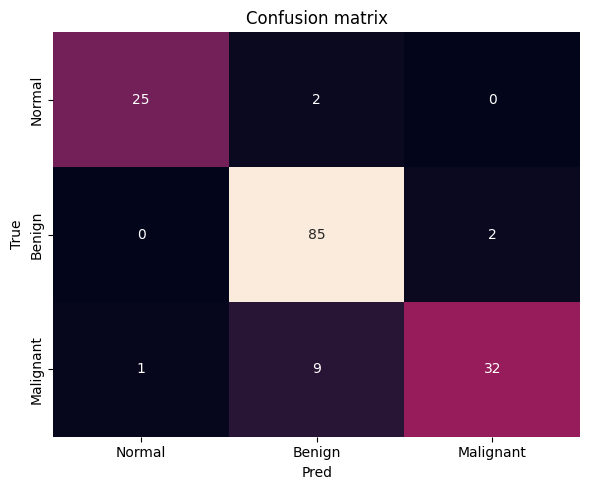

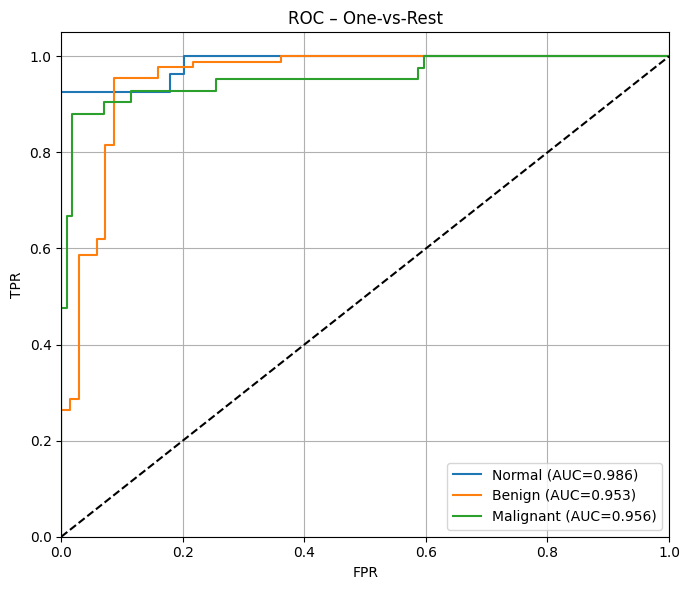


Macro-AUC : 0.9647956338794416

=== Good Cases (highest IoU) ===


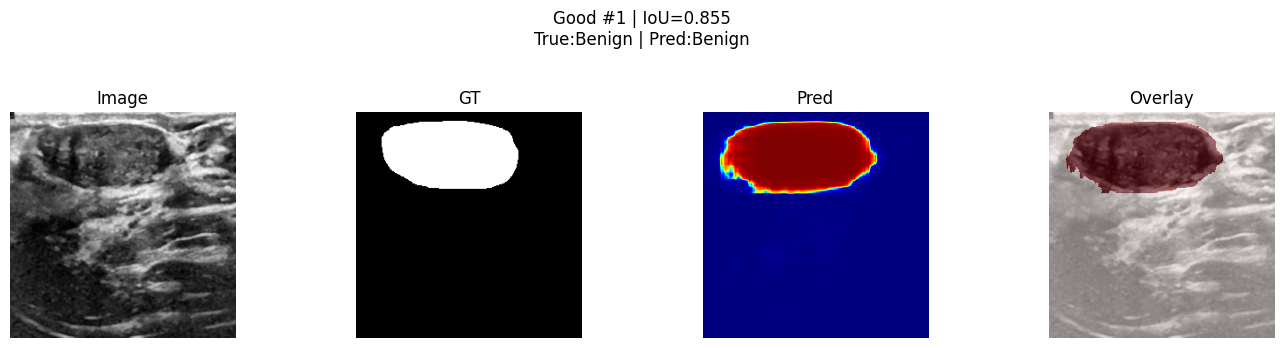

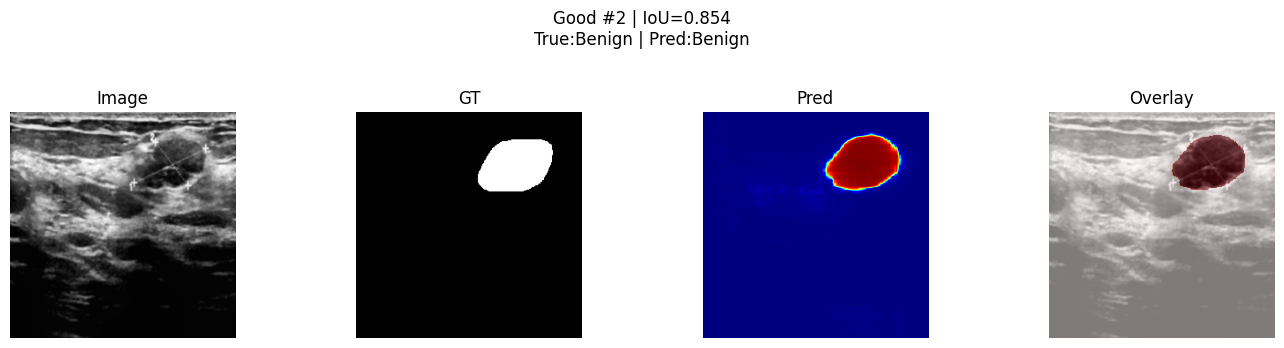

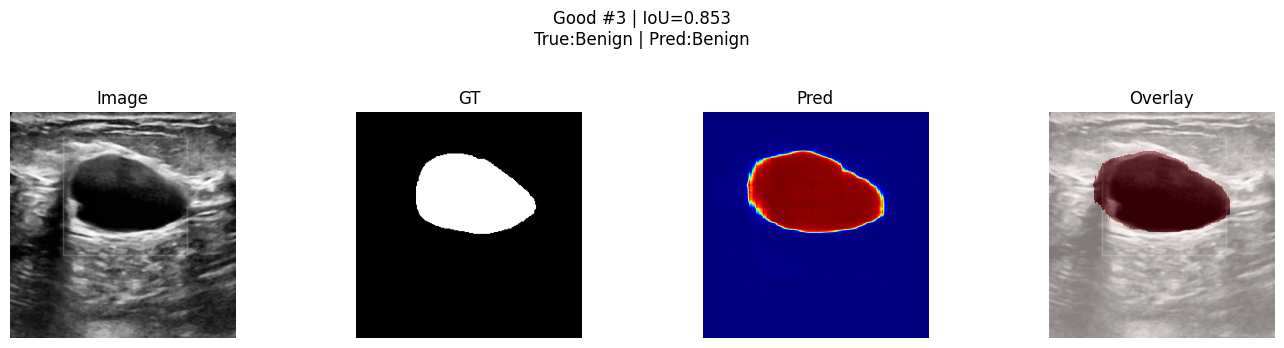


=== Challenging Cases (lowest IoU) ===


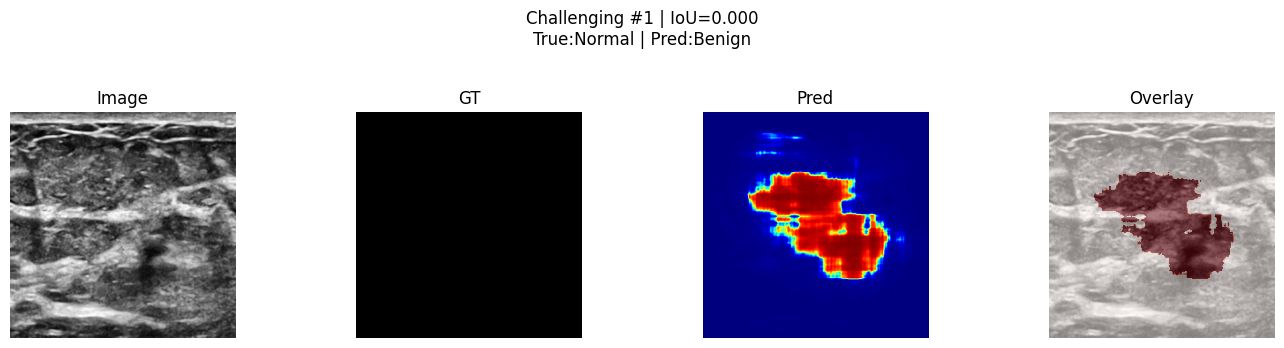

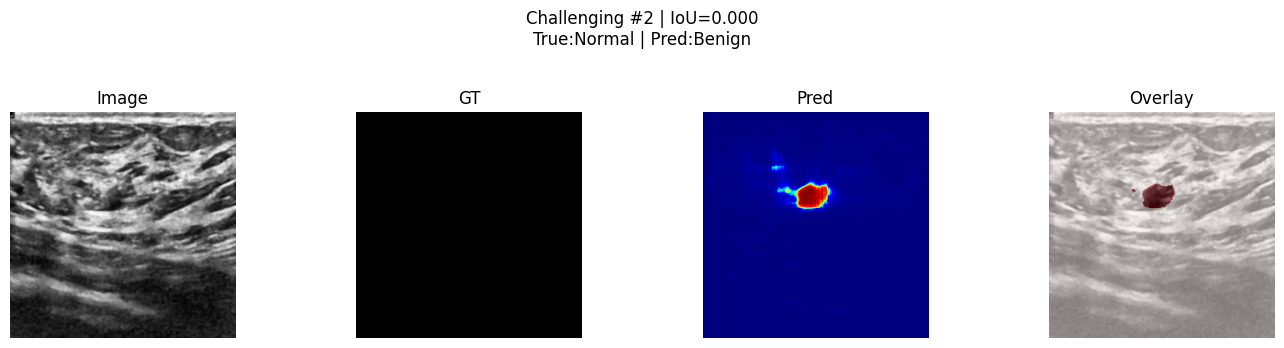

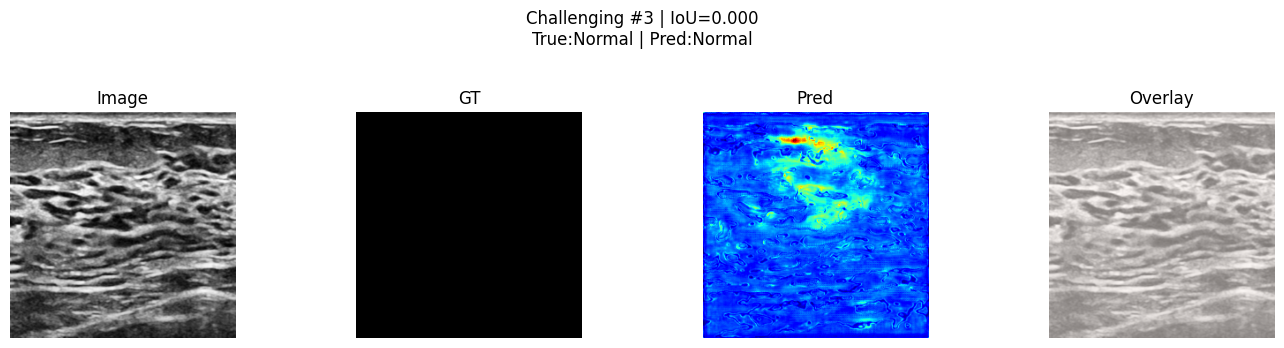


Torchinfo summary:

All done – best checkpoint saved to best_multitask_unet.pth


In [ ]:
# ============================================================
#  Quick inference sanity-check (single cell)
# ============================================================

import random, torch, cv2, numpy as np, matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T
from pathlib import Path

DEVICE   = 'cuda' if torch.cuda.is_available() else 'cpu'
IMG_SIZE = 256
CKPT     = '/kaggle/working/best_multitask_unet.pth'   # path to your file
CLASS_NAMES = ['Normal', 'Benign', 'Malignant']

In [ ]:
# ------------------------------------------------------------
# 1.  Re-load model weights  (robust to either file format)
# ------------------------------------------------------------
model.eval()        # 'model' exists from training

try:  # try the new safe loader first
    weights = torch.load(CKPT, map_location=DEVICE, weights_only=True)
    print('✓ Loaded weight-only file')
except Exception as e:
    print('weights_only=True failed -> falling back to full checkpoint')
    ckpt    = torch.load(CKPT, map_location=DEVICE)          # classic load
    weights = ckpt.get('model_state_dict', ckpt)             # pull weights
model.load_state_dict(weights, strict=True)
print('✓ Weights placed into model')

In [ ]:
# ------------------------------------------------------------
# 2.  Pre-processing utilities (same as training)
# ------------------------------------------------------------
def preprocess_cv(img_np):
    img_np = cv2.GaussianBlur(img_np, (5,5), 0)
    img_np = cv2.createCLAHE(2.0, (8,8)).apply(img_np)
    img_np = cv2.morphologyEx(img_np, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))
    return img_np

tensor_tf = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor()
])

def prepare_tensor(path):
    pil = Image.open(path).convert('L')
    pil = Image.fromarray(preprocess_cv(np.array(pil).astype(np.uint8)))
    return tensor_tf(pil).unsqueeze(0).to(DEVICE), pil  # tensor, PIL

In [ ]:
# ------------------------------------------------------------
# 3.  Inference function
# ------------------------------------------------------------
@torch.no_grad()
def run_inference(img_path, thr=0.5):
    x, pil_img = prepare_tensor(img_path)
    seg_logits, cls_logits = model(x)

    # classification
    probs = torch.softmax(cls_logits, 1).cpu().numpy()[0]
    cls   = int(probs.argmax())

    # segmentation
    mask_prob = torch.sigmoid(seg_logits).cpu().numpy()[0]
    mask_bin  = (mask_prob > thr).astype(np.uint8)

    # show
    fig, ax = plt.subplots(1,3, figsize=(12,4))
    ax[0].imshow(pil_img, cmap='gray');               ax[0].set_title('Pre-processed'); ax[0].axis('off')
    ax[1].imshow(mask_prob, cmap='jet');              ax[1].set_title('Mask probability'); ax[1].axis('off')
    ax[2].imshow(pil_img, cmap='gray'); ax[2].imshow(mask_bin, alpha=.5, cmap='Reds')
    ax[2].set_title(f'{CLASS_NAMES[cls]} ({probs[cls]:.2f})');  ax[2].axis('off')
    plt.tight_layout(); plt.show()

    print('Class probabilities [Normal, Benign, Malignant]:',
          np.round(probs, 3))
    return {'class': CLASS_NAMES[cls], 'probs': probs,
            'mask_prob': mask_prob, 'mask_bin': mask_bin}

weights_only=True failed -> falling back to full checkpoint
✓ Weights placed into model
Random BUSI image chosen:
 /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal/normal (105).png


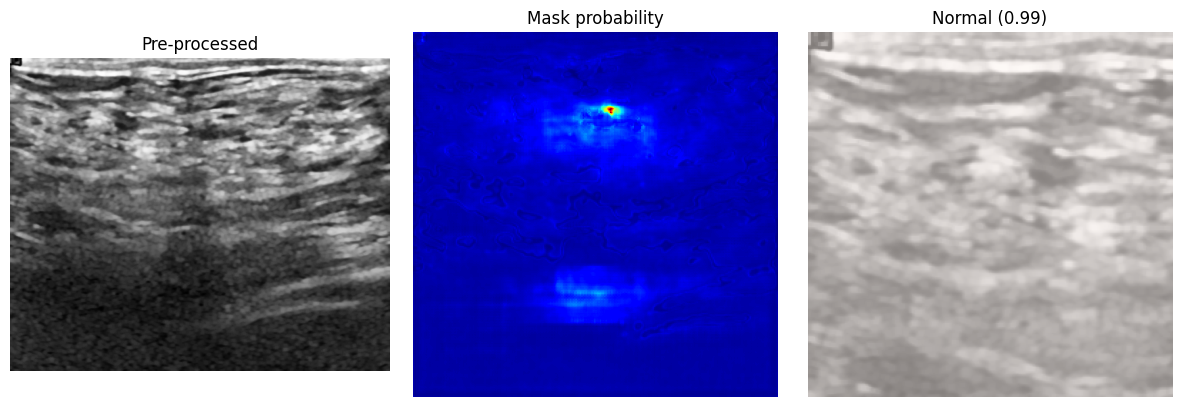

Class probabilities [Normal, Benign, Malignant]: [0.994 0.005 0.001]


In [ ]:
# ------------------------------------------------------------
# 4.  Pick an image to test
# ------------------------------------------------------------
TEST_IMG = None   # <-- replace with '/kaggle/input/.../your_scan.png' if desired

if TEST_IMG is None:
    # choose random BUSI image
    test_pool = sorted(Path(ROOT).rglob('*.png'))
    TEST_IMG = random.choice([p for p in test_pool if '_mask' not in p.name])
    print('Random BUSI image chosen:\n', TEST_IMG)

# ------------------------------------------------------------
# 5.  Run inference
# ------------------------------------------------------------
_ = run_inference(TEST_IMG, thr=0.5)